# **Project Title**: Face Generation Using Diffusion Model
### **Student**: Rohit Kumar Manne
### **Date**: 12/01/2024


## 1. Introduction

In this project, we aim to explore the potential of Diffusion Models in generating realistic human faces by combining different ethnic groups. The main objective is to create images that blend facial features from Orientals, Indians, and White Europeans.

### Key Objectives:
- Collect a diverse dataset of faces from three ethnic groups.
- Train a diffusion model to generate realistic faces.
- Explore the possibility of blending features from different ethnic groups.


## 2. Dataset Collection and Preprocessing

### 2.1 Data Collection, FairFace Dataset

For this project, we used the FairFace dataset, which provides facial images with race and gender annotations. The dataset is highly diverse, covering seven major racial groups, White, Black, Latino/Hispanic, East Asian, Southeast Asian, Indian, and Middle Eastern.

#### Selected Groups
From the dataset, we filtered images from the following racial groups:
1. Orientals
2. Indian
3. Europeans

We collected around 500 to 1000 images per group for training, ensuring balanced data for our diffusion model.

## 2. Imports and Setup

This cell handles all necessary imports and initial setup:
- PyTorch for deep learning framework
- Image processing libraries (PIL)
- Data handling utilities
- Visualization tools
- Device configuration (GPU/CPU)
- Google Drive mounting for data access
- Directory creation for output storage

In [28]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
drive.mount('/content/drive')

# Create necessary directories
base_dir = '/content/drive/MyDrive'
data_dir = os.path.join(base_dir, 'Dataset')
output_dir = os.path.join(base_dir, 'gen_images')
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "Mix_Faces"), exist_ok=True)

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Dataset Class
"""
FaceDataset class implementation:
- Handles loading of facial images from three ethnic groups
- Assigns labels: European (0), Indian (1), Oriental (2)
- Provides dataset statistics for monitoring
- Implements data transformations:
  * Resizing to 64x64
  * Converting to tensor
  * Normalizing pixel values
"""

In [29]:
# Cell 2: Dataset Class
class FaceDataset(Dataset):
    def __init__(self, european_path, indian_path, oriental_path, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        # Load images from each ethnicity
        paths = [(european_path, 0), (indian_path, 1), (oriental_path, 2)]
        for path, label in paths:
            for img_name in os.listdir(path):
                if img_name.lower().endswith('.jpg'):
                    self.images.append(os.path.join(path, img_name))
                    self.labels.append(label)

        # Print dataset statistics
        print("\nDataset Statistics:")
        print(f"European images (0): {self.labels.count(0)}")
        print(f"Indian images (1): {self.labels.count(1)}")
        print(f"Oriental images (2): {self.labels.count(2)}")
        print(f"Total images: {len(self.images)}\n")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.images[idx]).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {self.images[idx]}: {e}")
            return self.__getitem__(0)

## 4. Model Architecture
UNet architecture implementation:
- Incorporates time embeddings for diffusion process
- Includes label conditioning for ethnic control
- Features:
  * Sinusoidal position embeddings
  * Double convolution blocks
  * Skip connections
  * Up/Down sampling paths
- Enables controlled generation of facial features

In [30]:
import torch
import torch.nn as nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels + in_channels//2, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_dim=256, num_classes=3):
        super().__init__()
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.GELU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, time_dim)

        # Initial projection
        self.inc = DoubleConv(in_channels, 64)

        # Encoder path
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        # Time and label embedding projections
        self.time_embedding1 = nn.Linear(time_dim, 64)
        self.time_embedding2 = nn.Linear(time_dim, 128)
        self.time_embedding3 = nn.Linear(time_dim, 256)
        self.time_embedding4 = nn.Linear(time_dim, 512)

        # Bottleneck
        self.bot1 = DoubleConv(512, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 512)

        # Decoder path
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)

        # Output projection
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def pos_encoding(self, t, channels):
        return self.time_embedding1(t)[:, :, None, None].repeat(1, 1, 8, 8)

    def forward(self, x, t, label):
        # Time and label embeddings
        t = self.time_mlp(t.float())
        label_emb = self.label_embedding(label)
        t = t + label_emb

        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = x2 + self.time_embedding2(t)[:, :, None, None]

        x3 = self.down2(x2)
        x3 = x3 + self.time_embedding3(t)[:, :, None, None]

        x4 = self.down3(x3)
        x4 = x4 + self.time_embedding4(t)[:, :, None, None]

        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        # Decoder with skip connections
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)

        # Output
        return self.outc(x)

## 5. Diffusion Model
Core diffusion process implementation:
- Manages noise schedule (beta, alpha parameters)
- Handles forward process (noise addition)
- Controls sampling procedure:
  * Classifier-free guidance
  * Denoising steps
  * Image generation
- Parameters:
  * noise_steps: 1000
  * beta_start: 1e-4
  * beta_end: 0.02

In [31]:
# Cell 4: Diffusion Model
class DiffusionModel:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size

        # Calculate noise schedule
        self.beta = torch.linspace(beta_start, beta_end, noise_steps)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        # Move to device
        self.beta = self.beta.to(device)
        self.alpha = self.alpha.to(device)
        self.alpha_hat = self.alpha_hat.to(device)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        ε = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * ε, ε

    @torch.no_grad()
    def sample(self, model, n_samples, labels, guidance_scale=3.):
        model.eval()
        x = torch.randn((n_samples, 3, self.img_size, self.img_size)).to(device)

        for i in tqdm(reversed(range(self.noise_steps)), desc="Generating images"):
            t = (torch.ones(n_samples) * i).long().to(device)
            pred_noise = model(x, t, labels)

            # Classifier-free guidance
            if guidance_scale > 1:
                uncond_pred = model(x, t, torch.zeros_like(labels))
                pred_noise = torch.lerp(uncond_pred, pred_noise, guidance_scale)

            # Update sample
            alpha = self.alpha[i]
            alpha_hat = self.alpha_hat[i]
            beta = self.beta[i]

            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * pred_noise) + torch.sqrt(beta) * noise

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        return x

## 6. Training Functions
Training pipeline components:
1. train_epoch function:
   - Handles single epoch training
   - Calculates loss and updates model
   - Tracks progress with tqdm

2. generate_ethnic_combinations:
   - Creates mixed ethnic faces
   - Saves generated images
   - Supports various ethnic combinations:
     * Oriental-Indian
     * Oriental-European
     * Indian-European
     * Three-way combinations

In [32]:
# Cell 5: Training Functions
def train_epoch(model, diffusion, dataloader, optimizer, epoch):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for batch, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        t = torch.randint(0, diffusion.noise_steps, (images.shape[0],)).to(device)
        noisy_images, noise = diffusion.noise_images(images, t)
        predicted_noise = model(noisy_images, t, labels)

        loss = F.mse_loss(predicted_noise, noise)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"loss": total_loss / (batch + 1)})

    return total_loss / len(dataloader)

def generate_ethnic_combinations(model, diffusion, save_dir="generated_faces"):
    os.makedirs(save_dir, exist_ok=True)
    n_samples = 10
    combinations = [
        ("Oriental_Indian", [2, 1]),
        ("Oriental_European", [2, 0]),
        ("Indian_European", [1, 0]),
        ("Oriental_Indian_European", [2, 1, 0])
    ]

    for name, labels in combinations:
        print(f"\nGenerating {name} combinations...")
        if len(labels) == 2:
            batch_labels = torch.tensor(labels * (n_samples // 2)).to(device)
        else:
            batch_labels = torch.tensor(labels * (n_samples // 3 + 1))[:n_samples].to(device)

        samples = diffusion.sample(model, n_samples, batch_labels)

        # Save generated images
        plt.figure(figsize=(20, 4))
        for i in range(n_samples):
            plt.subplot(1, n_samples, i + 1)
            plt.imshow(samples[i].cpu().permute(1, 2, 0))
            plt.axis('off')
        plt.savefig(f"{save_dir}/{name}.png")
        plt.close()
        print(f"Saved {name} images")

## 7. Main Training Loop
Complete training execution:
- Dataset preparation:
  * Loading images
  * Creating dataloaders
- Model initialization
- Training configuration:
  * 250 epochs
  * Adam optimizer
  * Learning rate: 1e-4
- Progress tracking:
  * Loss plotting
  * Checkpoint saving

Epoch 249:   0%|          | 0/48 [00:00<?, ?it/s]

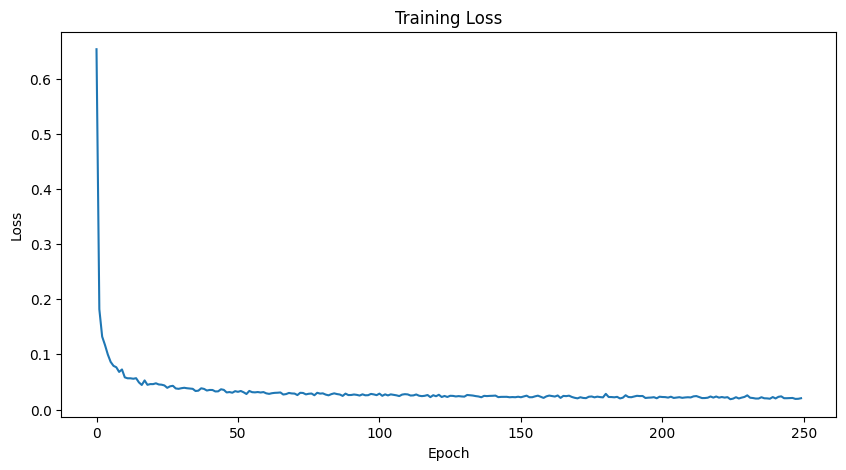

In [35]:
# Cell 6: Main Training Loop
# Set your paths here
european_path = "/content/drive/MyDrive/Dataset/european"
indian_path = "/content/drive/MyDrive/Dataset/indian"
oriental_path = "/content/drive/MyDrive/Dataset/orientals"

# Data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create dataset and dataloader
dataset = FaceDataset(european_path, indian_path, oriental_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# Initialize model and training
model = UNet().to(device)
diffusion = DiffusionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 250
losses = []

for epoch in range(num_epochs):
    loss = train_epoch(model, diffusion, dataloader, optimizer, epoch)
    losses.append(loss)

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f'diffusion_checkpoint_epoch_{epoch}.pt')

    clear_output(wait=True)

# 8. Generate Mixed Faces

Final generation and visualization:
1. Face generation:
   - Creates various ethnic combinations
   - Applies classifier-free guidance
2. Result visualization:
   - Saves generated images
   - Displays results in grid format
3. Quality assessment:
   - Visual inspection of blending
   - Feature preservation check


Generating Oriental_Indian combinations...


Generating images: 0it [00:00, ?it/s]

Saved Oriental_Indian images

Generating Oriental_European combinations...


Generating images: 0it [00:00, ?it/s]

Saved Oriental_European images

Generating Indian_European combinations...


Generating images: 0it [00:00, ?it/s]

Saved Indian_European images

Generating Oriental_Indian_European combinations...


Generating images: 0it [00:00, ?it/s]

Saved Oriental_Indian_European images


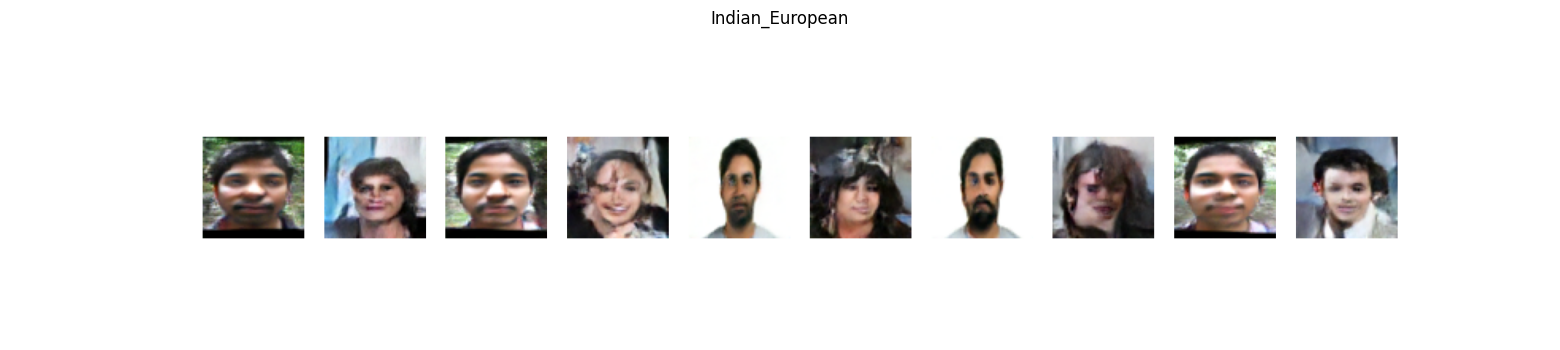

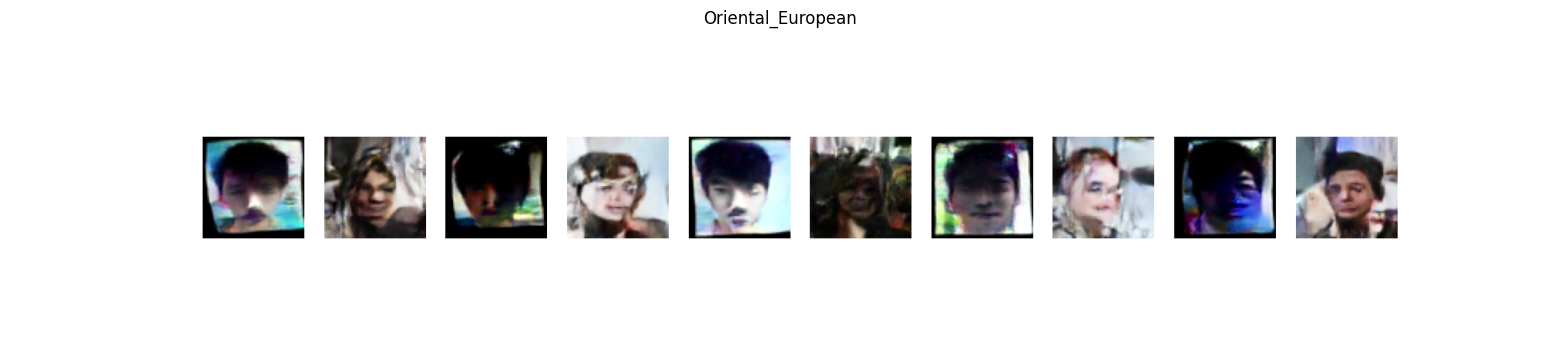

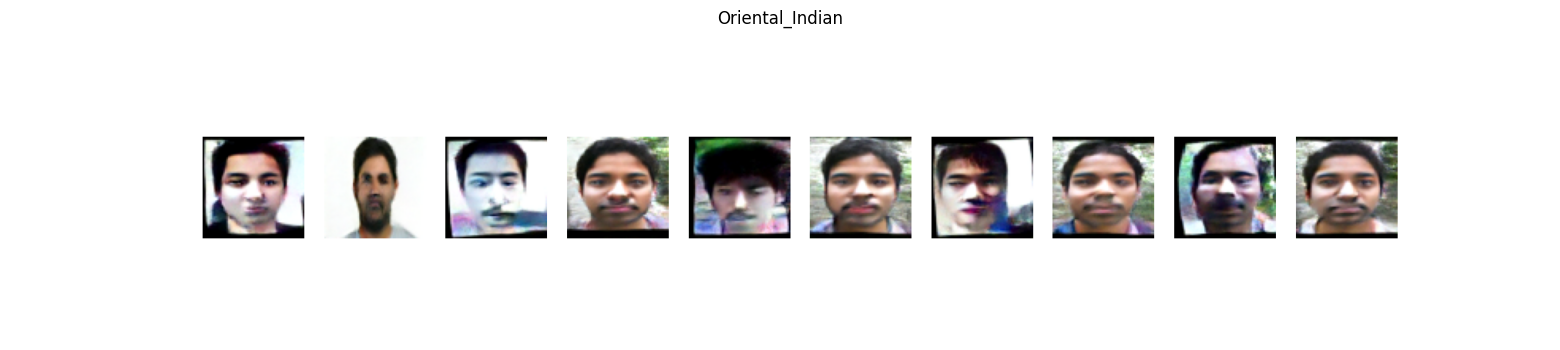

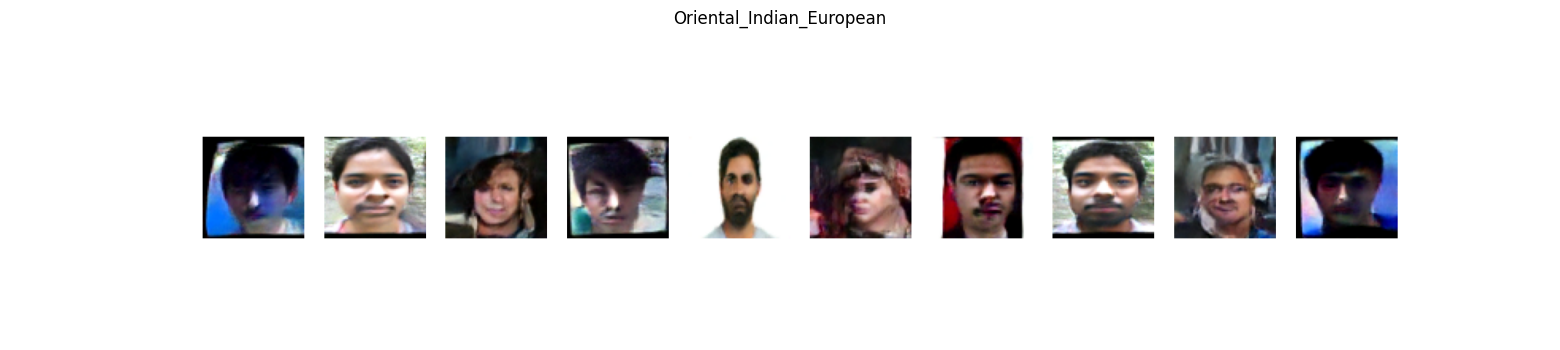

In [36]:
# Cell 7: Generate Mixed Faces
generate_ethnic_combinations(model, diffusion)

# Display results
def display_results(save_dir="generated_faces"):
    for img_path in sorted(os.listdir(save_dir)):
        if img_path.endswith('.png'):
            plt.figure(figsize=(20, 4))
            img = plt.imread(os.path.join(save_dir, img_path))
            plt.imshow(img)
            plt.title(img_path.replace('.png', ''))
            plt.axis('off')
            plt.show()

display_results()